# Monte Carlo Ising Model 2D

In [1]:
import numpy as np
from numba import jit
import math as math
import matplotlib.pyplot as plt
import statistics as stats
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from random import randint
from scipy.optimize import curve_fit
from scipy import stats

import timeit
%matplotlib inline

# Constants

In [13]:

J=1 #Strength of interaction (Joules)
K = 1 #Joules per kelvin

#Monte Carlo steps
mcsteps=50



In [3]:
#comments
@jit
def update(grid,size_grid,T):
    # Monte carlo loop
    for b in range(mcsteps):
        m[b]=np.sum(grid)/(size_grid)**2  # average of the magnetization(magnetization per spin)
#         m[b]=np.sum(grid)
    # Metropolis loop      
        for i in range(msteps): # equilibration steps to led the system relax after change one step of the temperature
            h=np.rint((size_grid-1)*np.random.rand())
            k=np.rint((size_grid-1)*np.random.rand())
            # calculating the number of neighbours of each cell
            neighbours=grid[np.mod(h+1,size_grid),k]+grid[np.mod(h-1,size_grid),k]+grid[h,np.mod(k+1,size_grid)]+grid[h,np.mod(k-1,size_grid)]       

            # Computing the halmiltonian for this spin j,k
            H[i]=J*grid[h,k]*neighbours
            #Calculating the change in energy by flipping a spin
            DeltaE=2*H[i]*J
            #Calculate the transition probabilities
            p_trans = np.exp(-DeltaE*1/(T))
            #Decide which transition will occur
            transitions = (np.random.rand() < p_trans) * (-2) + 1

            #Perform the transitions
            grid[h,k] *= transitions
            
       
        
    return grid,H,m


In [4]:
#comments
def simulation(grid,H,T,size_grid,m):

    # Energy per spin. factor of a half is introduced in order to account for the spins being counted twice. 
    E=-np.sum(H)/((size_grid)**2 )

    # Specific heat per site in units of J/K (eq 7.28 book)(k/J*tau*T=1/kT*T)
    cv=(np.mean(H*H)-np.mean(np.absolute(H))*np.mean(np.absolute(H)))/T**2
    
    # Susceptibility per spin (first value as the initial, which is zero)
    phi=(np.mean(m*m)-np.mean(np.absolute(m))*np.mean(np.absolute(m)))/T  # (<M^2>-<absM><absM>)/T
    return cv, E, phi



In [5]:
# Function that computes the critical exponents at diffrent lattice sizes of one magnitud of interest
def critical(size_grid,A,b):
    ratio=np.zeros(shape=(len(size_grid),))
    ratiocv=np.zeros(shape=(len(size_grid),))
    for i in range(len(size_grid)):
        k=np.log(np.amax(A[:,i]))
        kcv=np.amax(A[:,i])
        l=np.log(size_grid)
        ratio[i]=k/l[i]
        ratiocv[i]=kcv/l[i]
    
    z=np.polyfit(l,ratio,1)
    print(z)
    p = np.poly1d([z[0],z[1]])
    slope=z[0]
#     slope, intercept, r_value, p_value, std_err = stats.linregress(p, ratiocv)
#     popt, pcov = curve_fit(np.poly1d, l, ratio)
    crit=plt.figure(1)
    phiplot=plt.scatter(l, ratio,label='Data points')
    phiplot=plt.plot(l, p(l),label='Linear Fit'+  ',slope=%f'%(slope))
#     plt.title('Ln of ' + str(b) + ' vs Ln of lattice size')
    plt.title(str(b)+' vs Ln of Lattice size')
    plt.xlabel('Ln lattice sizes')
    plt.ylabel('Data points and a polynomio fit')
    legend = plt.legend(loc=4,fontsize=9)
    return slope,crit

In [6]:
def exact2D(T):
    a=math.exp(8/T)
    z=2*a+12+2/a
    Emean=-(16*a-16/a)/z
    Esqmean=(128*a+128/a)/z
    absMmean=(8*a+16)/z
    Msqmean=(32*a+32)/z
    cvexact2D=(Esqmean-Emean**2)/T**2
    phiexact2D=(Msqmean-absMmean**2)/(T*4)
    Tc=2.269
    if T<Tc:
        Mexact=math.pow((1-math.pow(math.sinh(math.log(1+math.sqrt(2))*Tc/T),-4)),1/8)
    else:
        Mexact=0                    
    return cvexact2D,phiexact2D,Mexact,Emean

In [10]:
# Plotting the observables along with the different sizes of the grid that have been taken
#comments
# input
# output

# magnitud of interest
def plotting(A,size_grid,b):
    colors = ['aquamarine', 'c', 'y', 'm', 'r']
#     A[0,:]=-1
    figA=plt.figure(1)
    plt.subplot(1,1,1)
    plt.title(str(b) + ' vs Temp')# put the name of A in the legend
    plt.xlabel('Temperature[J/k]', fontsize=10)
    plt.ylabel(str(b),fontsize=10)
    
    for i in range(len(size_grid)):
        mylegend=['L=6','L=12','L=18','L=24']# built this vector according size_grid
#         mylegend=['L=50']
        phiplot=plt.scatter(T, A[:,i], color=colors[i],label=mylegend[i])
        phiplot=plt.plot(T, A[:,i], color=colors[i])
        legend = plt.legend(loc=4)
    plt.show()  
    
    return figA

# Ising and observables

In [21]:
# Script to run the Metropolis algorithm and calculate the observables
# size_grid=np.array([2,6,10,15])
# size_grid=np.array([50])
size_grid=np.array([6,12,18,24,30,35])
T=np.linspace(0.5,10,100) #temperature
msteps=np.zeros(shape=(len(size_grid),))##Metropolis steps
xaxis = np.linspace(0,len(T),mcsteps)
cv=np.zeros(shape=(len(T),len(size_grid))) #init heat capacity
M=np.zeros(shape=(len(T),len(size_grid))) #init magnetization for plotting
phi=np.zeros(shape=(len(T),len(size_grid))) # init susceptibility
E=np.zeros(shape=(len(T),len(size_grid))) # init Energy
m=np.zeros(shape=(mcsteps))# init average magnetization

for j in range(len(size_grid)):
    msteps=size_grid[j]*size_grid[j]
    H=np.zeros(shape=(msteps,)) #init hamiltonian
    grid=np.zeros(shape=(size_grid[j],size_grid[j]))
    grid+=1
    for t in range(len(T)):
        cv[t,j],E[t,j],phi[t,j]=simulation(grid,H,T[t],size_grid[j],m)
        grid,H,m=update(grid,size_grid[j],T[t])
        M[t,j]=m[len(m)-1]

        

   
   
   

C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Saving observables



In [22]:
heat=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\cv_latt2.txt', cv, delimiter='\n') 
    
ene=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\E_latt2.txt', E, delimiter='\n')  
    
mag=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\M_latt2.txt', M, delimiter='\n')  

sus=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\phi_latt2.txt', phi, delimiter='\n')  
            
                

In [18]:
# Function to read the data of the observables as arrays
# size_grid=np.array([2,6,10,15])
#size_grid=np.array([50])
size_grid=np.array([6,12,18,24])
def readdata(data,size_grid):
    t=len(data)/len(size_grid)
    t1=np.zeros(shape=(t,))
    a=np.zeros(shape=(len(data)/len(size_grid),len(size_grid)))
    for i in range(len(t1)):
        a[i,:]=data[i*len(size_grid):i*len(size_grid)+len(size_grid)]
    return a

In [19]:
phi=np.loadtxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\phi_latt2.txt')
phi=readdata(phi,size_grid)
# len(cv)


C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Exact observables

In [ ]:

T=np.linspace(0.5,10,100) #temperature
cvexact2D=np.zeros(shape=(len(T),))
phiexact2D=np.zeros(shape=(len(T),))
Mexact=np.zeros(shape=(len(T),))
phionsa=np.zeros(shape=(len(T),))
Emean=np.zeros(shape=(len(T),))
for i in range(len(T)):
    cvexact2D[i],phiexact2D[i],Mexact[i],Emean[i]=exact2D(T[i])
    phionsa[i]=(np.mean(Mexact*Mexact)-np.mean(np.absolute(Mexact))*np.mean(np.absolute(Mexact)))/T[i]
# t=M[:,3]
# print(t)
# ind=np.where(t<0)
# t[ind]=0
mc=plt.figure(1)
E[0]=-4
plt.scatter(T,M,color='r',label='Data points')
plt.plot(T,M,color='r')
# plt.title('Susceptibility vs Temperature 50X50 grid')
# y.limits([0,0.007])
# plt.xlabel('Temperature [J/k]')
# plt.ylabel('Susceptibility')

# plt.legend(loc=1)

# ex=plt.figure(2)
plt.scatter(T,Mexact,color='b',label='Onsager solution')
plt.plot(T,Mexact,color='b')
plt.title('Magnetization:Onsager Solution vs MC')
plt.xlabel('Temperature [J/k]')
plt.ylabel('Magnetization')
plt.legend(loc=1)

In [ ]:
# mc.savefig('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\Pictures results\mc vs exact\m_1000MC.png')
mc.savefig('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\Pictures results\mc vs exact\M_exact vs mc_50X50.png')

# Critical exponents

[ 0.24912127 -2.24281544]


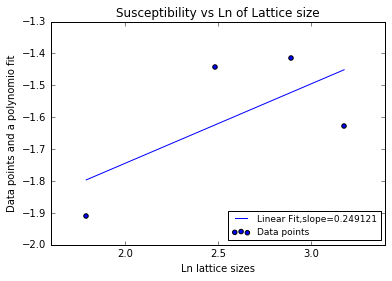

In [20]:
# phi=np.loadtxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\phi.txt')
a=M[0:20]
a=0.5
slope,crit=critical(size_grid,phi,'Susceptibility')
# print(err)
# crit.savefig('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\Pictures results\criticality\phi_50MC_20T points.png')

# Plotting


IndexError: list index out of range

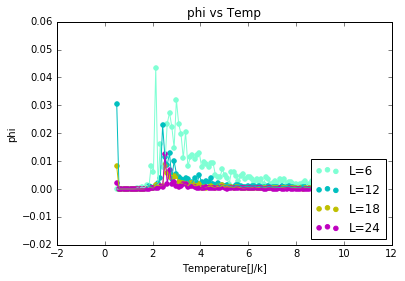

In [23]:
T=np.linspace(0.5,10,100) #temperature


figa=plotting(phi,size_grid,'phi')
# figa.savefig('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\Pictures results\E(50 MC).png')